In [6]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import cv2
import os
import xarray as xr

In [2]:
recpath = '/home/niell_lab/Data/freely_moving_ephys/new_hf_stim/worldcam_playback/041422/J559RT/hf4_worldcam'

In [5]:
os.listdir(recpath)

['041422_J599RT_control_Rig2_hf4_worldcam_REYEdeinter.avi',
 '041422_J599RT_control_Rig2_hf4_worldcam_REYE_plot.avi',
 '041422_J599RT_control_Rig2_hf4_worldcam_Ephys.bin',
 '041422_J599RT_control_Rig2_hf4_worldcam_IMU.bin',
 '041422_J599RT_control_Rig2_hf4_worldcam_REYE_BonsaiTS.csv',
 '041422_J599RT_control_Rig2_hf4_worldcam_speed.nc',
 '041422_J599RT_control_Rig2_hf4_worldcam_BALLMOUSE_BonsaiTS_X_Y.csv',
 '041422_J599RT_control_Rig2_hf4_worldcam_world.nc',
 '041422_J599RT_control_Rig2_hf4_worldcam_ephys_merge.json',
 '041422_J599RT_control_Rig2_hf4_worldcam_WORLD_BonsaiTS.csv',
 '041422_J599RT_control_Rig2_hf4_worldcam_REYE_BonsaiTSformatted.csv',
 '041422_J599RT_control_Rig2_hf4_worldcam_REYE_tracking_figs.pdf',
 '041422_J599RT_control_Rig2_hf4_worldcam_WORLD.avi',
 '041422_J599RT_control_Rig2_hf4_worldcam_REYE.nc',
 '041422_J599RT_control_Rig2_hf4_worldcam_WORLD_BonsaiTSformatted.csv',
 '041422_J599RT_control_Rig2_hf4_worldcam_WORLDcalib.avi',
 '041422_J599RT_control_Rig2_hf4_world

# Frame times

In [10]:
imu_path = os.path.join(recpath, '041422_J599RT_control_Rig2_hf4_worldcam_IMU.bin')

In [12]:
dtypes = np.dtype([
    ("acc_x",np.uint16),
    ("acc_y",np.uint16),
    ("acc_z",np.uint16),
    ("none1",np.uint16), # 3
    ("gyro_x",np.uint16),
    ("gyro_y",np.uint16),
    ("gyro_z",np.uint16),
    ("none2",np.uint16) # 7
])
imu = pd.DataFrame(np.fromfile(imu_path, dtypes, -1, '')).to_numpy()

In [21]:
from datetime import datetime
def read_timestamp_series(s):
    output_time = []
    fmt = '%H:%M:%S.%f'
    if s.dtype != np.float64:
        for current_time in s:
            str_time = str(current_time).strip()
            try:
                t = datetime.strptime(str_time, fmt)
            except ValueError as v:
                ulr = len(v.args[0].partition('unconverted data remains: ')[2])
                if ulr:
                    str_time = str_time[:-ulr]
            try:
                output_time.append((datetime.strptime(str_time, '%H:%M:%S.%f') - datetime.strptime('00:00:00.000000', '%H:%M:%S.%f')).total_seconds())
            except ValueError:
                output_time.append(np.nan)
        output_time = np.array(output_time)
    else:
        output_time = s.values
    return output_time

def read_timestamp_file(path):
    # read data and set up format
    s = pd.read_csv(path, encoding='utf-8', engine='c', header=None).squeeze()
    if s[0] == 0:
        s = s[1:]
    camT = read_timestamp_series(s)
    return camT

In [22]:
path = os.path.join(recpath, '041422_J599RT_control_Rig2_hf4_worldcam_Ephys_BonsaiBoardTS.csv')
imuT = read_timestamp_file(path)

In [32]:
t0 = imuT[0]
num_samp = np.size(imu,0)

In [33]:
imuT = list(np.array(t0 + np.linspace(0, num_samp-1, num_samp) / 30000))

In [48]:
useT = imuT-imuT[0]
use_onsets = imu[:,3]-np.median(imu)
use_diff = np.diff(use_onsets)
use_show = use_diff/np.max(use_diff)
use_show[use_show < 0] = 0
frame_onsets = useT[np.argwhere(use_show > 0.5).flatten()]

In [59]:
frame_onsets

0.00673333333543269

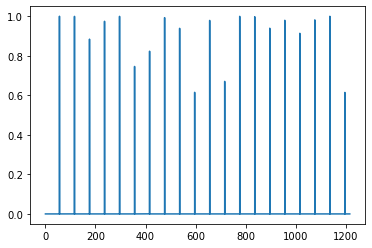

In [85]:
stimstart = imu[:,7]-np.median(imu)
stimstart_diff = np.diff(stimstart)
stimstart_diff = stimstart_diff/np.max(stimstart_diff)
stimstart_diff[stimstart_diff<0] = 0
stim_restarts = useT[np.argwhere(stimstart_diff > 0.5).flatten()]

# Saccade times

In [60]:
hffm = pd.read_pickle('/home/niell_lab/Data/freely_moving_ephys/batch_files/062022/hffm_062022_gt.pickle')

In [62]:
c = hffm[hffm['session']=='070921_J553RT_control_Rig2'].iloc[0]

In [74]:
saccdict = {
    'left_gaze': list(c['FmLt_gazeshift_left_saccTimes_dHead1']),
    'right_gaze': list(c['FmLt_gazeshift_right_saccTimes_dHead1']),
    'left_comp': list(c['FmLt_comp_left_saccTimes_dHead1']),
    'right_comp': list(c['FmLt_comp_right_saccTimes_dHead1'])
}

In [87]:
for startInd, startT in stim_restarts:
    for key, val in saccdict.items():
        

array([  56.1427    ,  116.17196667,  176.2011    ,  236.23046667,
        296.2596    ,  356.2889    ,  416.31803333,  476.34743333,
        536.37656667,  596.40583333,  656.43506667,  716.4643    ,
        776.49353333,  836.5229    ,  896.55203333,  956.58133333,
       1016.61043333, 1076.6397    , 1136.66903333, 1196.69823333])

# Saccade frames

In [ ]:
frame_onsets

# Ephys

In [ ]:
self.ephys_data = pd.read_json(self.ephys_json_path)
        if do_sorting:
            # sort units by shank and site order
            self.ephys_data = self.ephys_data.sort_values(by='ch', axis=0, ascending=True)
            self.ephys_data = self.ephys_data.reset_index()
            self.ephys_data = self.ephys_data.drop('index', axis=1)
        # spike times
        self.ephys_data['spikeTraw'] = self.ephys_data['spikeT'].copy()
        # select good cells from phy2
        self.cells = self.ephys_data.loc[self.ephys_data['group']=='good']
        self.units = self.cells.index.values